In [1]:
import os
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
import torch.utils.data as data
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from utils.data_loader import HE_Dataset
from copy import deepcopy

# Load dataset

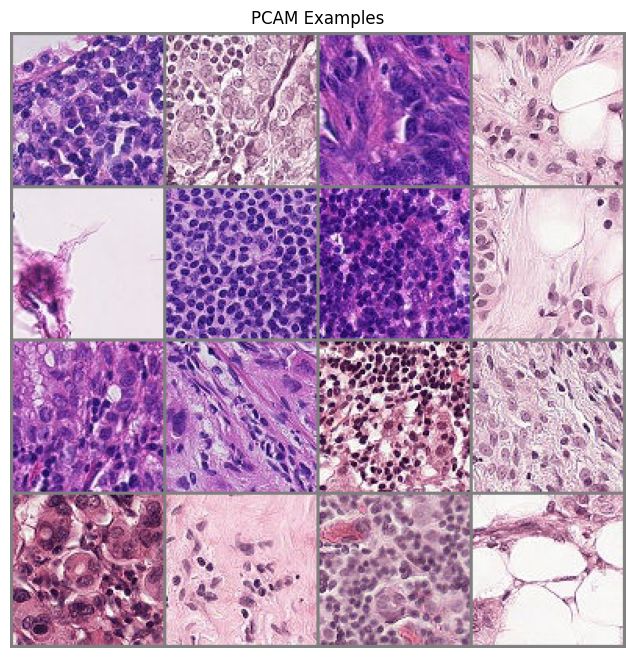

In [2]:
train_dataset = HE_Dataset()
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = HE_Dataset()
test_loader = data.DataLoader(test_dataset, batch_size=32)

examples = train_dataset[0:16][0]
examples = examples.permute(0, 3, 1, 2)
grid = make_grid(examples, nrow=4, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("PCAM Examples")
plt.imshow(grid)
plt.axis("off")
plt.show()
plt.close()

In [3]:
class Network(nn.Module):
    def __init__(self, f_act, input_size, output_size, hidden_sizes) -> None:
        super().__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), f_act]
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = x.reshape((x.shape[0], -1))
        x = self.layers(x)
        return x

In [4]:
def train(model, data_loader, optimizer, loss_module, device, epochs=100):
    model.train()
    for epoch in range(epochs):
        true_predictions = 0.0
        count = 0
        best_loss = float('inf')
        for x, y in tqdm(data_loader):
            x = x.to(device)
            y = y.to(device)
            y_h = model(x)
            # print(y_h.shape, y.shape)
            # y_h = y_h.squeeze(dim=1)
            loss = loss_module(y_h, y)
            if loss < best_loss:
                best_loss = loss
                best_state = deepcopy(model.state_dict())
                best_epoch = epoch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            y_h = (y_h >= 0.5).float()
            true_predictions += (y_h == y).sum()
            count += y.shape[0]
        
        train_acc = true_predictions / count
        print(f'Epoch {epoch}: Training accuracy = {train_acc}, loss = {loss}')
    torch.save(best_state, 'models/simple_model.tar')
    print(f'Best epoch: {best_epoch}')
    
def test(model, data_loader, device, epochs):
    model.eval()
    true_predictions = 0.0
    count = 0
    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x = x.to(device)
            y = y.to(device)
            
            y_h = model(x)
            # print(y.shape, y_h.shape)
            # y_h = y_h.squeeze(dim=1)
            y_h = torch.sigmoid(y_h)
            
            y_h = (y_h >= 0.5).float()
            true_predictions += (y_h == y).sum()
            count += y.shape[0]
    
    test_acc = true_predictions / count
    print(f'Test accuracy after {epochs} epochs = {test_acc}')

# Initializing model and params

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

input_size = 3 * 96 * 96
output_size = 1
layers = [2048, 1024, 512, 256, 128, 64]
epochs = 1
lr = 0.01

activation = nn.ReLU()
model = Network(activation, input_size, output_size, layers)
optimizer = torch.optim.SGD(model.parameters(), lr)
loss_module = nn.BCEWithLogitsLoss()

if os.path.exists('models/simple_model.tar'):
    state_dict = torch.load('models/simple_model.tar')
    model.load_state_dict(state_dict)
    print(model)
    
    model.to(device)
    
    train(model, train_loader, optimizer, loss_module, device, epochs)
    
    test(model, test_loader, device, epochs)
else:
    print('Model checkpoint unavialable')
    print(model)

    model.to(device)

    # Training the model
    train(model, train_loader, optimizer, loss_module, device, epochs)

    # Testing the model
    test(model, test_loader, device, epochs)

Device:  cuda
Network(
  (layers): Sequential(
    (0): Linear(in_features=27648, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


  0%|          | 0/8192 [00:00<?, ?it/s]

Epoch 0: Training accuracy = 0.8257980346679688, loss = 0.20053909718990326
Best epoch: 0


  0%|          | 0/8192 [00:00<?, ?it/s]

Test accuracy after 1 epochs = 0.825347900390625
